In [1]:
import pickle

x90_amp = 0.13281891815102317
qubit_freq = 4725773313.124915

with open("opt_pulse_data.pkl", "rb") as opt_file:
    opt_pulse_file_data = pickle.load(opt_file)

with open("drag_pulse_data.pkl", "rb") as drag_file:
    drag_pulse_file_data = pickle.load(drag_file)

Compute means and fit data.

In [9]:
from warnings import warn
from scipy.optimize import curve_fit
import numpy as np

def ffunc(x, initial, final, alpha):
    """Randomized benchmarking exponential"""
    exp_scale = 1
    return final + (initial - final) * alpha**(exp_scale*x)

def fit_data(data_dict):
    """This modifies the dictionary in place, adding popt, and pcov."""

    def initial_decay_guess(x, y):
        """ Return an initial guess as to where a function crosses 50% that is robust against a little bit
        of bad points.   Not immune if min/max(y) is corrupt. """
        y = np.array(y)
        midscale = (np.max(y)-np.min(y))/2 + np.min(y)
        bigger = 1.0*(y > midscale)
        # Look for the point where there are as many points less than midscale to the left as there
        # are points larger than midscale to the right
        left=np.cumsum(bigger)
        right=np.cumsum(1-bigger)
        right = right[-1] - right
        place = left-right # zero crossing in this is the right point
        # find first zero crossing
        place = place > 0
        crossing = np.argmax(place[0] != place)
        if crossing == 0:  # No sign change.. wtf?
            warn('Bad zero crossing; using median')
            return np.median(np.array(x))
        return x[crossing]

    from scipy.optimize import curve_fit

    # popt, pcov = curve_fit(ffunc, rbdat17_number_means, rbdat17_signal_means, sigma=np.sqrt(rbdat17_variance_means))


    iguess = {'initial': data_dict["rbdat_calibrated_signal"][0],
              'final': data_dict["rbdat_calibrated_signal"][-1],
              'alpha': 0.919}

    iguess['alpha'] = max(0.5,1.0-0.5/initial_decay_guess(
        data_dict["rbdat_clifford_numbers"], data_dict["rbdat_calibrated_signal"]
    ))

    x0 = []
    for label in iguess.keys():
        x0 = x0 + [iguess[label]]
    x0 = np.array(x0)

    popt, pcov = curve_fit(
        ffunc, data_dict["rbdat_clifford_numbers"],
        data_dict["rbdat_calibrated_signal"], x0,
        sigma=np.sqrt(data_dict["rbdat_calibrated_variance"]),
        absolute_sigma=True
    )
    
    data_dict["popt"] = popt
    data_dict["pcov"] = pcov
    data_dict["epc"] = (1 - popt[2]) / 2

def extract_data_and_fit(single_pulse_data):

    # separate out different portions of data, dropping any nan
    rbdat = []
    rbdat_clifford_numbers = np.array([])
    rbdat_calibrated_signal = np.array([])
    rbdat_calibrated_variance = np.array([])
    for new_rbdat in single_pulse_data:
        
        if any(np.max(np.isnan(x)) for x in new_rbdat):
            warn("dropping data for containing nan.")
        else:
        
            rbdat.append(new_rbdat)

            rbdat_clifford_numbers = np.append(rbdat_clifford_numbers, new_rbdat[0][:, 1])
            rbdat_calibrated_signal = np.append(rbdat_calibrated_signal, new_rbdat[1][0])
            rbdat_calibrated_variance = np.append(rbdat_calibrated_variance, new_rbdat[2][0])

    
    rbdat_rounds = 3 * len(rbdat)

    rbdat_number_means = np.mean(
        np.reshape(
            rbdat_clifford_numbers,
            (
                rbdat_rounds,
                int(len(rbdat_clifford_numbers)/rbdat_rounds)
            )
        ), axis=0
    )
    rbdat_signal_means = np.mean(
        np.reshape(
            rbdat_calibrated_signal,
            (
                rbdat_rounds,
                int(len(rbdat_calibrated_signal)/rbdat_rounds)
            )
        ), axis=0
    )
    rbdat_variance_means = np.mean(
        np.reshape(
            rbdat_calibrated_variance,
            (
                rbdat_rounds,
                int(len(rbdat_calibrated_variance)/rbdat_rounds)
            )
        ), axis=0
    )
    
    data_dict = {
        "rbdat": rbdat,
        "rbdat_clifford_numbers": rbdat_clifford_numbers,
        "rbdat_calibrated_signal": rbdat_calibrated_signal,
        "rbdat_calibrated_variance": rbdat_calibrated_variance,
        "rbdat_number_means": rbdat_number_means,
        "rbdat_signal_means": rbdat_signal_means,
        "rbdat_variance_means": rbdat_variance_means,
    }

    # add fit data, modifies dictionary in place
    fit_data(data_dict)
    
    return data_dict

def extract_and_fit_all_data(rb_file_data):

    all_fits = []
    for data in rb_file_data:
        fitted_data_dict = extract_data_and_fit(data["rbdat"])
        fitted_data_dict["freq_offset"] = data["freq_offset"]
        fitted_data_dict["amp_scale"] = data["amp_scale"]
        all_fits.append(fitted_data_dict)

    return all_fits

In [10]:
opt_pulse_data = extract_and_fit_all_data(opt_pulse_file_data)
drag_pulse_data = extract_and_fit_all_data(drag_pulse_file_data)

/var/folders/v5/5t1xdchn2ws5l1nj9h02vm0m0000gn/T/ipykernel_82658/2836367197.py:8: RuntimeWarning: overflow encountered in power
  return final + (initial - final) * alpha**(exp_scale*x)
/var/folders/v5/5t1xdchn2ws5l1nj9h02vm0m0000gn/T/ipykernel_82658/2836367197.py:72: UserWarning: dropping data for containing nan.
  warn("dropping data for containing nan.")


# Plotting RB curves

We could drop some of the data based on quality of the fits (where EPC is not necessarily the most meaningful).

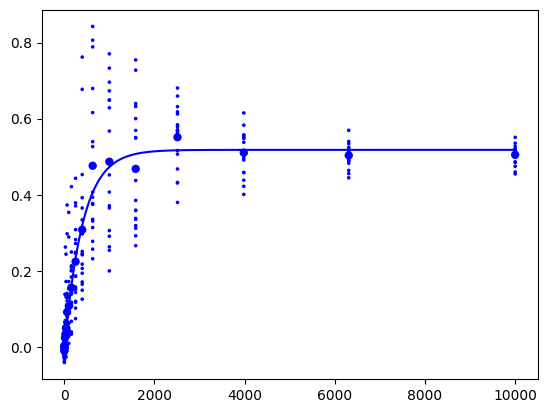

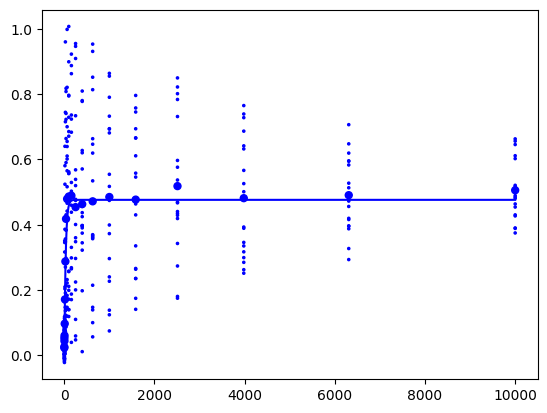

In [15]:
import matplotlib.pyplot as plt

plot_idx = -1

data_dict = opt_pulse_data[plot_idx]

plt.scatter(
    data_dict["rbdat_clifford_numbers"],
    data_dict["rbdat_calibrated_signal"],
    s = np.ones(len(data_dict["rbdat_calibrated_signal"]))*2.5,
    c = 'b'
)
plt.scatter(
    data_dict["rbdat_number_means"],
    data_dict["rbdat_signal_means"],
    s = np.ones(len(data_dict["rbdat_signal_means"]))*25,
    c = 'b'
)
plt.plot(
    np.linspace(0,10000,10000),
    ffunc(
        np.linspace(0,10000,10000),
        data_dict["popt"][0], data_dict["popt"][1], data_dict["popt"][2]
    ),
    c = 'b'
)
plt.show()

data_dict = drag_pulse_data[plot_idx]

plt.scatter(
    data_dict["rbdat_clifford_numbers"],
    data_dict["rbdat_calibrated_signal"],
    s = np.ones(len(data_dict["rbdat_calibrated_signal"]))*2.5,
    c = 'b'
)
plt.scatter(
    data_dict["rbdat_number_means"],
    data_dict["rbdat_signal_means"],
    s = np.ones(len(data_dict["rbdat_signal_means"]))*25,
    c = 'b'
)
plt.plot(
    np.linspace(0,10000,10000),
    ffunc(
        np.linspace(0,10000,10000),
        data_dict["popt"][0], data_dict["popt"][1], data_dict["popt"][2]
    ),
    c = 'b'
)
plt.show()

In [ ]:
# As suggested by Ken, may want to consider removing any data that deviates too significantly from
# the exponential
excluded_indices = []

# 2d plots

In [17]:
# create 2d grids of the data, mapping freq_offset, amp_scale -> EPC

freq_offset_vals = np.linspace(-1e6, 1e6, 9)
scale_vals = np.linspace(0.9, 1.1, 9)

opt_epc_grid = np.zeros((9, 9), dtype=float)
drag_epc_grid = np.zeros((9, 9), dtype=float)

for opt_data, drag_data in zip(opt_pulse_data, drag_pulse_data):
    # the indices are consistent
    freq_idx = np.argmin(np.abs(freq_offset_vals - opt_data["freq_offset"]))
    scale_idx = np.argmin(np.abs(scale_vals - opt_data["amp_scale"]))
    
    opt_epc_grid[freq_idx, scale_idx] = opt_data["epc"]
    drag_epc_grid[freq_idx, scale_idx] = drag_data["epc"]

2d plot of drag_EPC - opt_EPC as a function of freq/amp

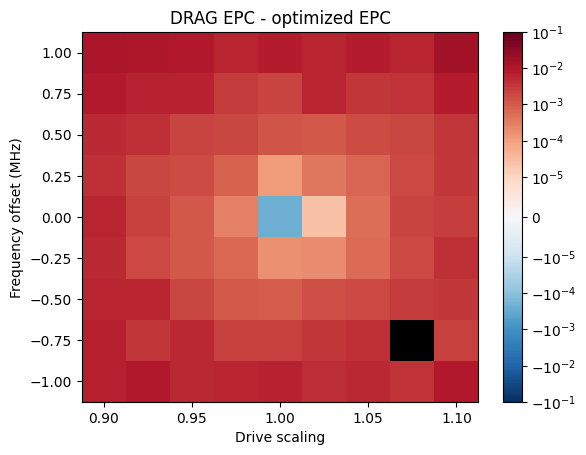

In [19]:
import matplotlib
import matplotlib.colors as colors

# helper function for 2D meshplots
def cell_centered(arr_in):
    arr_out = np.empty(len(arr_in)+1)
    dist = arr_in[1] - arr_in[0]
    for i in range(len(arr_in)):
        arr_out[i] = arr_in[i] - dist/2
    arr_out[-1] = arr_in[-1] + dist/2
    return arr_out

freq_corners = cell_centered(freq_offset_vals)
scale_corners = cell_centered(scale_vals)

cb_min = -1e-1
cb_max = -cb_min

diff = drag_epc_grid - opt_epc_grid
# set missing data point
diff[1, -2] = np.nan

fig, ax1 = plt.subplots(1, 1)

cmap = matplotlib.cm.RdBu_r
cmap.set_bad('black', 1.)

im = ax1.pcolormesh(
    scale_corners, 
    freq_corners / 1e6,
    diff,
    norm=colors.SymLogNorm(linthresh=1e-5, vmin=cb_min, vmax=cb_max),
    cmap=cmap
)
ax1.set_title("DRAG EPC - optimized EPC")
ax1.set_xlabel("Drive scaling")
ax1.set_ylabel("Frequency offset (MHz)")
plt.colorbar(im)
plt.show()

Plot showing regions in which the pulses achieve at most some EPC.

This plot needs a lot of work (colors are awful :D), but just wanted to try out the idea.

For each plot we are coloring the pixels based on whether or not `EPC < x` for some `x` for DRAG and/or the optimized pulse. The colors mean:
- "black": missing data
- "white": neither drag or opt pulse have `EPC < x`
- "red": opt pulse `EPC < x` but drag pulse `EPC > x`
- "blue": both opt and drag pulse `EPC < x`

There are no regions where only the drag pulse has `EPC < x` in these plots.

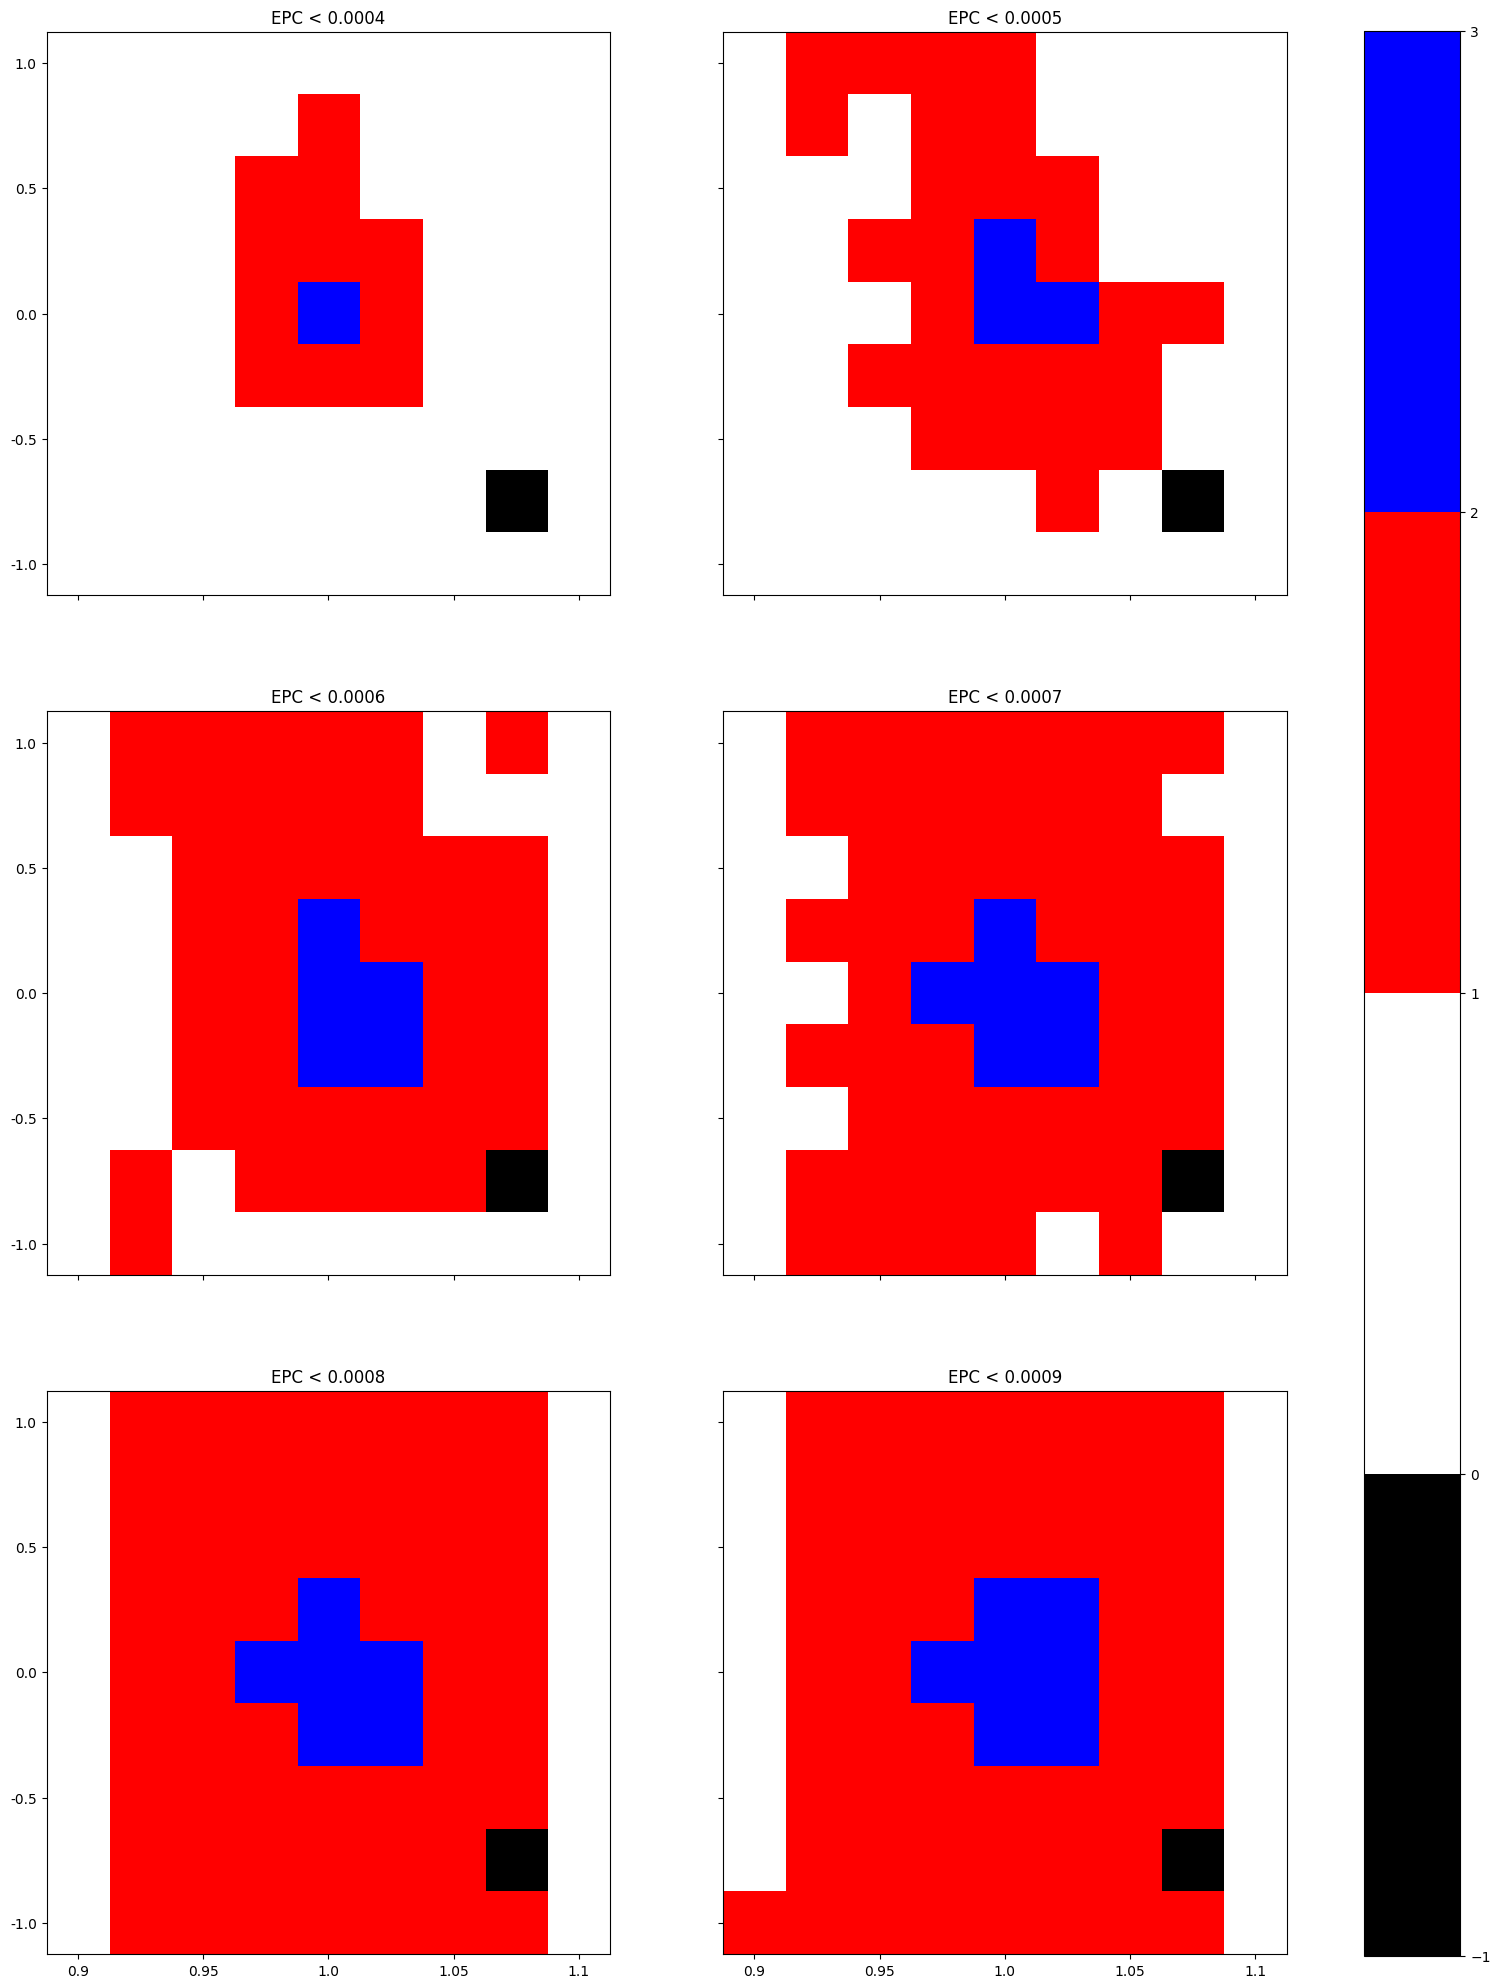

In [21]:
import matplotlib.colors as colors

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
values = [-1, 0, 1, 2, 3]
colors = ['black', 'white', 'red', 'blue', '#0000FF']
cmap = ListedColormap(colors)
norm = BoundaryNorm(values, len(colors))

cutoffs = np.array(
    [
        [4e-4, 5e-4],
        [6e-4, 7e-4],
        [8e-4, 9e-4]
    ]
)



fig, axes = plt.subplots(
    nrows=cutoffs.shape[0],
    ncols=cutoffs.shape[1],
    sharex="col", sharey="row",
    figsize=(20, 25)
)



for idx_row, axes_row in enumerate(axes):
    for idx_col, ax in enumerate(axes_row):
        current_cutoff = cutoffs[idx_row, idx_col]
        epc_combined = np.array(np.flip(opt_epc_grid, axis=0) < current_cutoff, dtype=int) + np.array(np.flip(drag_epc_grid, axis=0) < current_cutoff, dtype=int)
        epc_combined[-2, -2] = -1
        
        im = ax.imshow(
            epc_combined,
            norm=norm,
            cmap=cmap
        )

        ax.set_yticks(np.arange(0, 9, 2))
        ax.set_yticklabels(np.flip(freq_offset_vals[np.arange(0, 9, 2)] / 1e6))
        ax.set_xticks(np.arange(0, 9, 2))
        ax.set_xticklabels(np.round(scale_vals[np.arange(0, 9, 2)], 3))
        ax.set_title(f"EPC < {current_cutoff}")

#axes[1].set_xticks(np.arange(0, 9, 2))
#axes[1].set_xticklabels(np.round(scale_vals[np.arange(0, 9, 2)], 3))
plt.colorbar(im, ax=axes)
plt.show()